In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [3]:
from pettingzoo.test import parallel_api_test
from models.custom_gym import CustomGymEnviornment
from sar.solution.trainer import *
from sar.solution.policy_net import *

In [4]:
from core.agent import *
from core.world import * 
from core.render import * 
from core.skill import * 
from core.models import *
from core.message import *

In [5]:
DEVICE = "cuda"
BELIEF_DIMS = 5


In [6]:
from sar.sar_agent import *
from sar.sar_world import *
from sar.sar_env_params import MAX_TIME_STEPS
from sar.sar_traits_sampler import *

belief_initializer = SARBeliefInitializer(BELIEF_DIMS)
trait_sampler = SARTraitSampler()

def initialize_swarm(world : BaseWorld):
    swarm = trait_sampler.generate(SWARM_SIZE, DEVICE)
    for agent in swarm:
        agent.set_utility(SARUtilityFunction())
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    swarm = belief_initializer.initialize_beliefs(swarm)

In [7]:

from sar.urban_gen import * 
from sar.victims import * 
from sar.sar_comm import *
from sar.utils.geo import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)

GEO_TIFF_PATH = "C:\\Users\\Joaquin\\Desktop\\Thesis-Playground\\datasets\\output_SRTMGL1.tif"
geo_map = read_tiff(GEO_TIFF_PATH)[0]


def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)

    tx, ty = geo_map.shape
    if tx > world._dims[0] or ty > world._dims[1]:
        start_x = np.random.randint(0, tx - world._dims[0] + 1)
        start_y = np.random.randint(0, ty - world._dims[1] + 1)
        height_map = geo_map[start_x:start_x + world._dims[0], start_y:start_y + world._dims[1]]
        minimum = height_map.min()
        maximum = height_map.max() 
        terrain_map = TerrainMap(height_map, terrain_map._padding, minimum, maximum)


    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)
    
    visibility_map = BaseMap(np.zeros(world._dims, dtype = np.float32), terrain_map._padding)
    map_collection.add_map("Exploration", visibility_map)

    total_victims = world.get_param("total_victims")
    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims, total_victims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [8]:
from sar.energy import EnergyModel
from sar.victims import VictimModel
from sar.solution.sar_action_interpreter import *
from sar.solution.encoder_net import *
from sar.solution.decoder_net import *
from models.complex_model import * 

world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

In [9]:
from sar.solution.complex_initializer import * 
grid_size = 2 * 3 + 1

complex_model = ComplexModel(
    device="cuda",
    initializer_fn= sar_initializer_fn,
    config = SARModelConfig(
        belief_dims= BELIEF_DIMS,
        action_dims= 4,
        grid_size= grid_size,
        latent_dims= 16,
        state_dims= 2,
        trait_dims = 3,
        packet_dims = 2
    )
)

comms_protocol = SARCommunicationProtocol(complex_model._encoder_net, complex_model._decoder_net)
action_interpreter = SARActionInterpreter(BELIEF_DIMS)

custom_gym : CustomGymEnviornment = CustomGymEnviornment(world, action_interpreter, comms_protocol, time_step_upper= MAX_TIME_STEPS)

complex_model.to(DEVICE)
custom_gym.to(DEVICE)

In [10]:
custom_gym.reset(42)

({1: {'Belief': tensor([0., 0., 0., 0., 0.]),
   'Traits': tensor([  1.0000, 160.2313,   0.6199], device='cuda:0'),
   'Vision': array([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
   'Terrain': array([[76, 78, 79],
          [77, 79, 79],
          [76, 78, 75]], dtype=int16),
   'State': tensor([0.1602, 1.0000], device='cuda:0'),
   'Exploration': array([[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]], dtype=float32)},
  2: {'Belief': tensor([0., 0., 0., 0., 0.]),
   'Traits': tensor([2.0000e+00, 1.8827e+02, 1.0000e-02], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 1.],
          [0., 1., 0., 0., 0.]]),
   'Terrain': array([[53, 53, 52, 54, 55],
          [50, 51, 51, 53, 54],
          [48, 50, 51, 52, 54],
          [43, 44, 49, 51, 53],
          [37, 42, 48, 50, 51]], dtype=int16),
   'State': tensor([0.1883, 0.0000], device='cuda:0'),
   'Exp

### Testing

In [11]:
parallel_api_test(custom_gym, num_cycles=1_000)
custom_gym.reset()

c:\Users\Joaquin\Desktop\Thesis-Playground\v2\sar\solution\encoder_net.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)        # Normalize so that it doesn't explode


Passed Parallel API test


({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Traits': tensor([  1.0000, 160.2313,   0.6199], device='cuda:0'),
   'Vision': array([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
   'Terrain': array([[76, 78, 79],
          [77, 79, 79],
          [76, 78, 75]], dtype=int16),
   'State': tensor([0.1602, 1.0000], device='cuda:0'),
   'Exploration': array([[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]], dtype=float32)},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Traits': tensor([2.0000e+00, 1.8827e+02, 1.0000e-02], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 1.],
          [0., 1., 0., 0., 0.]]),
   'Terrain': array([[53, 53, 52, 54, 55],
          [50, 51, 51, 53, 54],
          [48, 50, 51, 52, 54],
          [43, 44, 49, 51, 53],
          [37, 42, 48, 50, 51]], dtype=int16),
   'State': tensor([0.1883, 

# Training

In [12]:

from models.base import * 
from models.idqn import * 
import matplotlib.pyplot as plt

In [13]:
model = IDQN(env = custom_gym,
             feature_extractor= feature_extractor,
             target_net= complex_model.get_target_net(),
             model= complex_model,
             batch_size=1024,
             device = DEVICE,
             buffer_size= int (MAX_TIME_STEPS * 10)
             )

In [14]:
rewards = train_loop(
    custom_gym, 
    model, 
    games_per_checkpoint=50,
    checkpoints=1,
    optimization_passes = 1, 
    difficulty_rate= 2,
    seed=42)

Training on thesis.


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Progress: 100%|██████████| 1/1 [01:27<00:00, 87.30s/it]

Finished training on thesis.


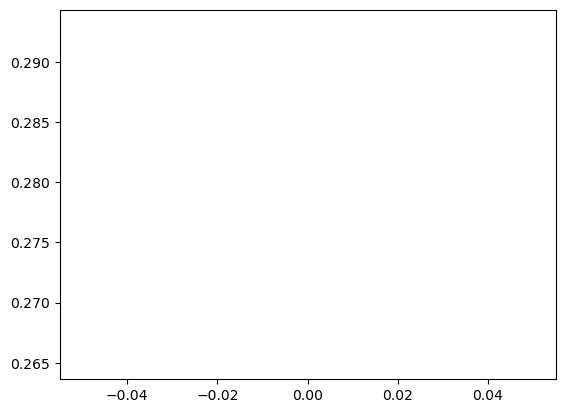

In [15]:
plt.plot(rewards)

# Optimizations

In [16]:
import cProfile

In [17]:
def stress_test():
    train_loop( custom_gym, 
        model, 
        games_per_checkpoint=1,
        checkpoints=1,
        optimization_passes = 1, 
        difficulty_rate= 2,
        seed=42
    )

In [18]:
cProfile.run('stress_test()', sort = 'time')

Training on thesis.


Training Progress: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]

Finished training on thesis.
         4323617 function calls (4322596 primitive calls) in 3.870 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    12313    0.628    0.000    0.628    0.000 {method 'item' of 'torch._C.TensorBase' objects}
    17936    0.627    0.000    0.627    0.000 {method 'to' of 'torch._C.TensorBase' objects}
        8    0.290    0.036    0.395    0.049 terrain_map.py:22(compute_gradient_map)
      556    0.161    0.000    0.161    0.000 {built-in method torch.stack}
      444    0.132    0.000    0.567    0.001 _lazy.py:994(_get_str)
     8426    0.092    0.000    0.092    0.000 {built-in method torch.tensor}
   307344    0.087    0.000    0.142    0.000 _td.py:2485(_get_str)
   332497    0.084    0.000    0.110    0.000 enum.py:193(__get__)
   313388    0.072    0.000    0.089    0.000 _lazy.py:1106(<genexpr>)
   100798    0.067    0.000    0.142    0.000 {built-in method builtins.issubclass}
   3200

# Visualization

In [19]:
from models.base import RenderWrapper

renderer = RenderWrapper(model=model)
latest_policy = max(
                glob.glob(f"{custom_gym.metadata['name']}*.zip"), key=os.path.getctime
            )
model = model.load(latest_policy)

c:\Users\Joaquin\Desktop\Thesis-Playground\v2\models\base.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [20]:
renderer.render()